In [1]:
import numpy as np
import random
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

num_drones = 8
drone_id = 0
population = []
the_map = None

In [2]:
class Drone:
    id = 0
    x = 0
    y = 0
    rely_on = []
    def __init__(self):
        global drone_id
        self.id = drone_id
        drone_id += 1
        self.rely_on = []
        

In [3]:
def vertices_of_regpoly(n, r):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        x.append(r * math.cos(2 * math.pi * i / n))
        y.append(r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [4]:
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 1)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]

In [5]:
class Swarm:
    drones = []
    connectedness = []
    def __init__(self, drones):
        self.drones = drones
        self.connectedness = assign_connectedness(drones)
        global drone_id
        drone_id = 0
        set_init_drones(self)
        
  

In [6]:
def assign_connectedness(drones):
    connectedness = np.zeros((len(drones),len(drones)))
    
    #The upper traingle of a mtrix w/o diagonal is filled in with 1s
    #the diagonal would mean drones are connected to themselves
    #the lower triangle is just a reflection
    #representation of the connections between drones
    for i in range(0,len(drones)):
        for j in range(0, i):
            connectedness[j][i] = 1 #if random.random() > 0.5 else 0
            #connectedness[i][j] = connectedness[j][i]
           
    # Ensure that each drone has at least one connection
    for i in range(0,len(drones)):
        possible_values = np.nonzero(connectedness[i])[0].tolist()
        choice = random.choice(possible_values) if possible_values else -1
        if choice != -1:
            possible_values.remove(choice)
        #Remaining choices have a possibility of not being connections (probability related to the number of drones)
        for value in possible_values:
            connectedness[i][value] = 0 if random.random() > 1.0/float(len(drones)) else 1

    #reflect over diagonal axis of matrix to make symmetric matrix
    for i in range(0,len(drones)):
        for j in range(0, i):
            connectedness[i][j] = connectedness[j][i]
    
    for i in range(0,len(drones)):
        for j in range(0, len(drones)):
            if connectedness[i][j] == 1:
                drones[i].rely_on.append(j)
            
    return connectedness
     

In [7]:
def create_starting_population(size):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member(num_drones))
        
    return population

In [8]:
def create_new_member(num_drones):
    drones = []
    for i in range(0, num_drones):
        drones.append(Drone())
    member = Swarm(drones)
    return member

In [9]:
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        
        circle1 = plt.Circle((drone.x, drone.y), 10, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [120]:
class GeoMap:
    search_points = []
    def __init__(self, size):
        self.size = size
        self.draw_map()
        self.populate_search_points()
        
    def draw_map(self):
        map_size = self.size / 2
        plt.plot([-map_size,-map_size, map_size, map_size, -map_size], 
                 [-map_size, map_size, map_size,-map_size, -map_size])
        
    def populate_search_points(self):
        for i in range(-int(self.size/2), int(self.size/2)):
            for j in range(-int(self.size/2), int(self.size/2)):
                self.search_points.append([i,j, False])

In [121]:
def drone_distance(drone1, drone2):
    return math.hypot(drone2.x - drone1.x, drone2.y - drone1.y)

def drone_sig_strength(drone_dist):
    return 1/math.pow(drone_dist,2)

def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , drone_sig_strength(dist)])
    return swarm_strength

In [122]:
#https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    return 2*((1.0/(1+ np.exp(-1*x)))-0.5)

class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        print(self.input)
        self.weights1   = np.random.rand(self.input.shape[1], 3)
        print(self.weights1)
        self.weights2   = np.random.rand(3, 2)  
        print(self.weights2)
        
        self.output = np.zeros(y.shape)
        
    def feedforward(self):
        #For simplicity, biases are assumed to be zero
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        print(self.layer1)
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
        print(self.output)

In [123]:
def init():
    global population
    population = create_starting_population(1)
    for swarm in population:
        plot_swarm(swarm)
        global the_map
        the_map = GeoMap(100)

        print(swarm_sig_strength(swarm))
        

In [124]:
def scatter():
    for swarm in population:
        for drone in swarm.drones:
            for i in range(0, 3000):
                drone.x += random.random() - .5
                drone.y += random.random() - .5
        plot_swarm(swarm)
        the_map.draw_map()
        

        print(swarm_sig_strength(swarm))

[[[1, 2], 0.7653668647301795, 1.707106781186548], [[0, 3], 1.8477590650225735, 0.2928932188134525], [[0, 4], 2.0, 0.25], [[0, 5], 1.8477590650225737, 0.2928932188134524], [[1, 5], 2.0, 0.25], [[2, 5], 1.8477590650225735, 0.2928932188134525], [[4, 5], 0.7653668647301796, 1.7071067811865475], [[4, 6], 1.4142135623730951, 0.4999999999999999], [[2, 7], 1.8477590650225737, 0.2928932188134524], [[3, 7], 2.0, 0.25], [[5, 7], 1.414213562373095, 0.5000000000000001], [[6, 7], 0.7653668647301796, 1.7071067811865475]]


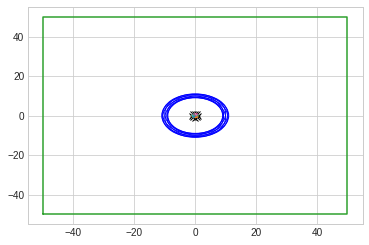

In [125]:
init()

[[[1, 2], 36.82103005120173, 0.0007375783032685616], [[0, 3], 22.11772071887346, 0.002044180589725969], [[0, 4], 40.685316762952226, 0.0006041219238495396], [[0, 5], 58.40988041309578, 0.0002931077933066666], [[1, 5], 81.72856512133994, 0.00014971049679998695], [[2, 5], 63.46207607598403, 0.0002482969868418958], [[4, 5], 41.14307892000629, 0.0005907536620300802], [[4, 6], 28.193413554742307, 0.001258069623612479], [[2, 7], 24.907762204416418, 0.0016118721007418756], [[3, 7], 18.890074626525095, 0.0028024163153469845], [[5, 7], 38.90089721659528, 0.0006608163256970011], [[6, 7], 29.165600833582424, 0.001175596121773957]]


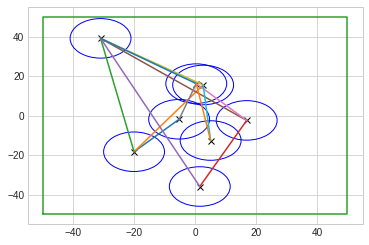

In [126]:
scatter()

In [127]:
x = [-1 , 4 , -2, 30, -90]
y = np.array([[0],[0],[0],[0]])
input = np.array([x])
nn = NeuralNetwork(input, y)


[[ -1   4  -2  30 -90]]
[[0.08236552 0.93708088 0.38459756]
 [0.92448329 0.75500363 0.82917112]
 [0.30124923 0.79601001 0.89499461]
 [0.18817306 0.29696224 0.73411885]
 [0.53167319 0.21126382 0.33660875]]
[[0.82618194 0.44255314]
 [0.71572768 0.11609051]
 [0.80457198 0.46236001]]


In [128]:
nn.feedforward()

[[-1.         -0.99986643 -0.99839844]]
[[-0.82508751 -0.47004168]]
